A parallel version of XOR using `neat.parallel`.

Since XOR is a simple experiment, a parallel version probably won't run any
faster than the single-process version, due to the overhead of
inter-process communication.

If your evaluation function is what's taking up most of your processing time
(and you should check by using a profiler while running single-process),
you should see a significant performance improvement by evaluating in parallel.

This example is only intended to show how to do a parallel experiment
in neat-python.  
You can of course roll your own parallelism mechanism
or inherit from `ParallelEvaluator` if you need to do something more complicated.


In [1]:
import math
import os
import time
import pickle

import neat
import pandas as pd
import numpy as np

import visualize

In [2]:
data = pd.read_csv('trainRW.csv')
data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12
0,8.0,0.180,0.37,0.9,0.049,36.0,109,0.99007,2.89,0.44,12.7,6
1,8.0,0.180,0.37,0.9,0.049,36.0,109,0.99007,2.89,0.44,12.7,6
2,7.3,0.650,0.00,1.2,0.065,15.0,21,0.99460,3.39,0.47,10.0,7
3,5.4,0.835,0.08,1.2,0.046,13.0,93,0.99240,3.57,0.85,13.0,7
4,8.7,0.820,0.02,1.2,0.070,36.0,48,0.99520,3.20,0.58,9.8,5


In [3]:
labels = data.loc[:,'Var12']
labels.head()

0    6
1    6
2    7
3    7
4    5
Name: Var12, dtype: int64

In [4]:
outputs = [ np.array([1 if x == idx-1 else 0 for x in range(10)]) for idx in labels]
predictors = data.loc[:, 'Var1':'Var11']
len(predictors.values[0])

11

In [5]:
def eval_genome(genome, config):
    """
    This function will be run in parallel by ParallelEvaluator.  It takes two
    arguments (a single genome and the genome class configuration data) and
    should return one float (that genome's fitness).
    Note that this function needs to be in module scope for multiprocessing.Pool
    (which is what ParallelEvaluator uses) to find it.  Because of this, make
    sure you check for __main__ before executing any code (as we do here in the
    last few lines in the file), otherwise you'll have made a fork bomb
    instead of a neuroevolution demo. :)
    """
    
    N_total = 350
    
    # Grab some random subset of test data
    test_data = data.sample(n=N_total)
    test_predictors = test_data.loc[:, 'Var1':'Var11'].values
    test_labels = test_data.loc[:,'Var12']
    test_outputs = [np.array([1 if x == idx-1 else 0 for x in range(10)]) for idx in test_labels]

    net = neat.nn.FeedForwardNetwork.create(genome, config)
    N_perfect = 0
    N_near = 0
    N_bad = 0
    
    confidence_err = 0
    
    err = 0
    
    for xi, xo in zip(test_predictors, test_outputs):
        outputs = net.activate(xi)
        err -= np.sum(np.square(np.subtract(xo, outputs)))
                
#         prediction = output.index(max(output))
#         answer = xo.tolist().index(max(xo))
#         for idx, output in enumerate(outputs):
#             if idx == answer:
#                 N_perfect += output
#             elif np.abs(idx - answer) == 1:
#                 N_near += output
#             else:
#                 N_bad += output
            
            #total_output = np.sum(output)
            #output_err = np.abs(total_output - 1)
            #confidence_err += output_err
#         error = abs(prediction - answer)
#         if error == 0:
#             N_perfect += 1
#         elif error == 1:
#             N_near += 1
#         else:
#             N_bad += 1
    
    
#     score = (2*N_perfect + N_near - 2*N_bad)/N_total
    #score = (2*N_perfect - N_near - 2*N_bad)/(N_total)# - confidence_err/N_total

    return err


In [6]:
def run(config_file):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)

    # Run for up to 10)00 generations.
    pe = neat.ParallelEvaluator(4, eval_genome)
    winner = p.run(pe.evaluate, 5000)
    try:
        with open('winner.pickle', 'wb') as f:
            pickle.dump(winner, f)

        # Display the winning genome.
        print('\nBest genome:\n{!s}'.format(winner))

        # Show output of the most fit genome against training data.
        print('\nOutput:')
        winner_net = neat.nn.FeedForwardNetwork.create(winner, config)

        # Use whole dataset for validation
        predictors = data.loc[:, 'Var1':'Var11'].values
        labels = data.loc[:,'Var12']
        outputs = [np.array([1 if x == idx-1 else 0 for x in range(10)]) for idx in labels]

        # setup confusion matrix
        confusion = np.zeros([10,10])

        for xi, xo in zip(predictors, outputs):
            output = winner_net.activate(xi)
            print("input {!r}\nexpected output {!r}\ngot {!r}".format(xi, xo, output))
            expected = xo.tolist().index(max(xo))
            prediction = output.index(max(output))
            confusion[expected][prediction] += 1

        print(confusion)

        #node_names = {-1:'A', -2: 'B', 0:'A XOR B'}
        visualize.draw_net(config, winner, True)
        visualize.plot_stats(stats, ylog=False, view=True)
        visualize.plot_species(stats, view=True)
    except Exception as e:
        print(e)
    
    return p

In [7]:
# Determine path to configuration file. This path manipulation is
# here so that the script will run successfully regardless of the
# current working directory.
local_dir = os.getcwd()
config_path = os.path.join(local_dir, 'config-feedforward')


 ****** Running generation 0 ****** 

Population's average fitness: -1740.00940 stdev: 405.05982
Best fitness: -586.44489 - size: (10, 110) - species 1 - id 280
Average adjusted fitness: 0.517
Mean genetic distance 1.189, standard deviation 0.136
Population of 500 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   500   -586.4    0.517     0
Total extinctions: 0
Generation time: 26.418 sec

 ****** Running generation 1 ****** 

Population's average fitness: -1397.84964 stdev: 382.16210
Best fitness: -338.37255 - size: (10, 109) - species 1 - id 961
Average adjusted fitness: 0.500
Mean genetic distance 1.197, standard deviation 0.152
Population of 500 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   500   -338.4    0.500     0
Total extinctions: 0
Generation time: 26.452 sec (26.435 average)

 ****** Running generation 2 ****** 

Population's avera

Mean genetic distance 1.996, standard deviation 0.228
Population of 500 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   17   500   -310.7    0.816     8
Total extinctions: 0
Generation time: 25.478 sec (25.832 average)

 ****** Running generation 18 ****** 

Population's average fitness: -504.40556 stdev: 195.71810
Best fitness: -303.02708 - size: (12, 104) - species 1 - id 8612
Average adjusted fitness: 0.813
Mean genetic distance 1.956, standard deviation 0.268
Population of 500 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   18   500   -303.0    0.813     9
Total extinctions: 0
Generation time: 25.315 sec (25.777 average)

 ****** Running generation 19 ****** 

Population's average fitness: -499.96058 stdev: 181.62442
Best fitness: -303.10851 - size: (11, 97) - species 1 - id 9339
Average adjusted fitness: 0.790
Mean genetic distance 1.948, standard d

Mean genetic distance 1.923, standard deviation 0.198
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   33   292   -302.0    0.819     8
     2   13   208   -306.2    0.811     2
Total extinctions: 0
Generation time: 22.904 sec (23.776 average)

 ****** Running generation 34 ****** 

Population's average fitness: -505.69431 stdev: 203.56846
Best fitness: -299.28068 - size: (13, 88) - species 1 - id 16424
Average adjusted fitness: 0.824
Mean genetic distance 1.923, standard deviation 0.214
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   34   125   -299.3    0.814     9
     2   14   375   -303.0    0.834     3
Total extinctions: 0
Generation time: 22.747 sec (23.588 average)

 ****** Running generation 35 ****** 

Population's average fitness: -490.51810 stdev: 191.84392
Best fitness: -296.58630 - size: (13, 88) - species

Population's average fitness: -468.57987 stdev: 196.49885
Best fitness: -303.61362 - size: (17, 96) - species 2 - id 23613
Average adjusted fitness: 0.840
Mean genetic distance 2.181, standard deviation 0.212
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   49   231   -306.7    0.835    10
     2   29   269   -303.6    0.845    14
Total extinctions: 0
Generation time: 23.082 sec (22.474 average)

 ****** Running generation 50 ****** 

Population's average fitness: -480.94118 stdev: 201.77530
Best fitness: -298.03306 - size: (15, 79) - species 2 - id 24448
Average adjusted fitness: 0.866
Mean genetic distance 2.107, standard deviation 0.229
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   50   129   -302.9    0.858    11
     2   30   371   -298.0    0.874    15
Total extinctions: 0
Generation time: 21.248 sec (22.358 ave

Population's average fitness: -483.33434 stdev: 223.15064
Best fitness: -293.68257 - size: (13, 73) - species 2 - id 31457
Average adjusted fitness: 0.828
Mean genetic distance 2.196, standard deviation 0.236
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   65   236   -301.2    0.827    26
     2   45   264   -293.7    0.829     4
Total extinctions: 0
Generation time: 19.921 sec (22.026 average)

 ****** Running generation 66 ****** 

Population's average fitness: -475.39690 stdev: 213.94206
Best fitness: -295.88594 - size: (22, 95) - species 2 - id 32383
Average adjusted fitness: 0.830
Mean genetic distance 2.256, standard deviation 0.277
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   66   261   -306.2    0.806    27
     2   46   239   -295.9    0.854     5
Total extinctions: 0
Generation time: 19.778 sec (21.866 ave

Population's average fitness: -483.65986 stdev: 252.83822
Best fitness: -258.68557 - size: (13, 61) - species 2 - id 39398
Average adjusted fitness: 0.880
Mean genetic distance 2.264, standard deviation 0.224
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   81   204   -299.9    0.884     2
     2   61   296   -258.7    0.876     3
Total extinctions: 0
Generation time: 17.897 sec (18.450 average)

 ****** Running generation 82 ****** 

Population's average fitness: -489.99946 stdev: 247.96637
Best fitness: -257.69666 - size: (12, 62) - species 2 - id 38055
Average adjusted fitness: 0.875
Mean genetic distance 2.295, standard deviation 0.213
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   82   253   -282.1    0.871     3
     2   62   247   -257.7    0.879     4
Total extinctions: 0
Generation time: 17.668 sec (18.344 ave

Population's average fitness: -486.26122 stdev: 281.13436
Best fitness: -251.59050 - size: (12, 52) - species 2 - id 47006
Average adjusted fitness: 0.854
Mean genetic distance 1.948, standard deviation 0.216
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   97   288   -251.7    0.852     5
     2   77   212   -251.6    0.857    10
Total extinctions: 0
Generation time: 16.999 sec (16.915 average)

 ****** Running generation 98 ****** 

Population's average fitness: -474.70127 stdev: 269.75419
Best fitness: -237.75681 - size: (14, 64) - species 1 - id 47347
Average adjusted fitness: 0.841
Mean genetic distance 2.012, standard deviation 0.221
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   98   215   -237.8    0.832     0
     2   78   285   -246.9    0.851    11
Total extinctions: 0
Generation time: 16.862 sec (16.905 ave

Population's average fitness: -457.74527 stdev: 257.57447
Best fitness: -240.60623 - size: (13, 59) - species 1 - id 54866
Average adjusted fitness: 0.872
Mean genetic distance 2.065, standard deviation 0.248
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  113   283   -240.6    0.876    15
     2   93   217   -247.3    0.868    26
Total extinctions: 0
Generation time: 16.644 sec (17.012 average)

 ****** Running generation 114 ****** 

Population's average fitness: -479.88503 stdev: 286.37075
Best fitness: -242.43993 - size: (16, 63) - species 1 - id 54967
Average adjusted fitness: 0.843
Mean genetic distance 2.111, standard deviation 0.242
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  114   311   -242.4    0.843    16
     2   94   189   -244.4    0.842    27
Total extinctions: 0
Generation time: 16.924 sec (17.004 av

Population's average fitness: -463.61423 stdev: 280.79898
Best fitness: -248.71865 - size: (12, 47) - species 1 - id 62499
Average adjusted fitness: 0.874
Mean genetic distance 2.097, standard deviation 0.215
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  129   233   -248.7    0.860    31
     2  109   267   -252.6    0.889    42
Total extinctions: 0
Generation time: 16.730 sec (16.592 average)

 ****** Running generation 130 ****** 

Population's average fitness: -467.00095 stdev: 277.50764
Best fitness: -244.33991 - size: (18, 54) - species 2 - id 62635
Average adjusted fitness: 0.888
Mean genetic distance 2.096, standard deviation 0.238
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  130   416   -250.8    0.884    32
     2  110    84   -244.3    0.891    43
Total extinctions: 0
Generation time: 17.357 sec (16.623 av

Population's average fitness: -423.33880 stdev: 239.91303
Best fitness: -238.48815 - size: (15, 46) - species 2 - id 70249
Average adjusted fitness: 0.886
Mean genetic distance 2.223, standard deviation 0.236
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  145   295   -248.3    0.882    47
     2  125   205   -238.5    0.890    58
Total extinctions: 0
Generation time: 16.334 sec (16.609 average)

 ****** Running generation 146 ****** 

Population's average fitness: -438.16657 stdev: 242.21668
Best fitness: -234.61496 - size: (18, 61) - species 1 - id 70490
Average adjusted fitness: 0.864
Mean genetic distance 2.195, standard deviation 0.260
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  146   281   -234.6    0.864     0
     2  126   219   -247.2    0.865    59
Total extinctions: 0
Generation time: 16.006 sec (16.534 av

Population's average fitness: -393.61886 stdev: 186.72446
Best fitness: -246.89332 - size: (18, 48) - species 2 - id 77552
Average adjusted fitness: 0.905
Mean genetic distance 2.261, standard deviation 0.445
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  161   214   -249.8    0.892    15
     2  141   286   -246.9    0.917    74
Total extinctions: 0
Generation time: 16.880 sec (16.870 average)

 ****** Running generation 162 ****** 

Population's average fitness: -403.03589 stdev: 211.80018
Best fitness: -237.72700 - size: (17, 47) - species 2 - id 78268
Average adjusted fitness: 0.908
Mean genetic distance 2.235, standard deviation 0.425
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  162   233   -244.5    0.912    16
     2  142   267   -237.7    0.904    75
Total extinctions: 0
Generation time: 16.136 sec (16.812 av

Population's average fitness: -411.62545 stdev: 185.93009
Best fitness: -245.57876 - size: (22, 55) - species 2 - id 83979
Average adjusted fitness: 0.861
Mean genetic distance 2.481, standard deviation 0.391
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  177   246   -246.8    0.849    31
     2  157   254   -245.6    0.873    90
Total extinctions: 0
Generation time: 16.346 sec (16.825 average)

 ****** Running generation 178 ****** 

Population's average fitness: -423.70235 stdev: 226.62859
Best fitness: -246.50242 - size: (21, 53) - species 1 - id 84131
Average adjusted fitness: 0.896
Mean genetic distance 2.400, standard deviation 0.383
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  178   234   -246.5    0.886    32
     2  158   266   -248.3    0.906    91
Total extinctions: 0
Generation time: 17.692 sec (16.849 av

Population's average fitness: -379.57972 stdev: 173.84669
Best fitness: -245.07799 - size: (22, 54) - species 1 - id 92464
Average adjusted fitness: 0.923
Mean genetic distance 2.557, standard deviation 0.479
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  193   248   -245.1    0.916    47
     2  173   252   -247.3    0.930    11
Total extinctions: 0
Generation time: 17.258 sec (16.885 average)

 ****** Running generation 194 ****** 

Population's average fitness: -388.93814 stdev: 176.20927
Best fitness: -245.42941 - size: (20, 51) - species 1 - id 91264
Average adjusted fitness: 0.900
Mean genetic distance 2.522, standard deviation 0.487
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  194   247   -245.4    0.891    48
     2  174   253   -246.4    0.909    12
Total extinctions: 0
Generation time: 17.154 sec (16.828 av

Population's average fitness: -382.75573 stdev: 184.27712
Best fitness: -240.05925 - size: (21, 55) - species 1 - id 100913
Average adjusted fitness: 0.904
Mean genetic distance 2.423, standard deviation 0.434
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  209   250   -240.1    0.902    63
     2  189   250   -249.0    0.907    27
Total extinctions: 0
Generation time: 15.988 sec (16.517 average)

 ****** Running generation 210 ****** 

Population's average fitness: -366.63756 stdev: 157.70584
Best fitness: -242.70559 - size: (23, 54) - species 1 - id 100977
Average adjusted fitness: 0.888
Mean genetic distance 2.452, standard deviation 0.418
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  210   251   -242.7    0.891    64
     2  190   249   -248.2    0.886    28
Total extinctions: 0
Generation time: 15.371 sec (16.303 

Population's average fitness: -366.13918 stdev: 206.65460
Best fitness: -244.60062 - size: (30, 66) - species 2 - id 106505
Average adjusted fitness: 0.943
Mean genetic distance 2.614, standard deviation 0.489
Population of 500 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  225   222   -246.2    0.937    79
     2  205   252   -244.6    0.950    43
     3    0    26       --       --     0
Total extinctions: 0
Generation time: 17.856 sec (17.559 average)

 ****** Running generation 226 ****** 

Population's average fitness: -375.45162 stdev: 198.38157
Best fitness: -237.61351 - size: (30, 69) - species 2 - id 109149
Average adjusted fitness: 0.925
Mean genetic distance 2.604, standard deviation 0.466
Population of 501 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  226   169   -248.0    0.907    80
     2  206   211   -237.6    0.941    44
     3    1   1

Population's average fitness: -366.46446 stdev: 136.08973
Best fitness: -239.90437 - size: (22, 51) - species 3 - id 115123
Average adjusted fitness: 0.883
Mean genetic distance 2.368, standard deviation 0.349
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  240   269   -239.9    0.885    13
     3   15   231   -239.9    0.880     0
Total extinctions: 0
Generation time: 14.830 sec (15.303 average)

 ****** Running generation 241 ****** 

Population's average fitness: -385.63331 stdev: 180.23832
Best fitness: -243.15542 - size: (29, 71) - species 1 - id 115845
Average adjusted fitness: 0.894
Mean genetic distance 2.325, standard deviation 0.354
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  241   268   -243.2    0.912    14
     3   16   232   -244.3    0.876     1
Total extinctions: 0
Generation time: 16.113 sec (15.310 

Population's average fitness: -361.28239 stdev: 157.24698
Best fitness: -238.31018 - size: (27, 61) - species 1 - id 123441
Average adjusted fitness: 0.901
Mean genetic distance 2.339, standard deviation 0.491
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  256   252   -238.3    0.915     3
     3   31   248   -244.0    0.887     7
Total extinctions: 0
Generation time: 16.712 sec (16.255 average)

 ****** Running generation 257 ****** 

Population's average fitness: -374.14660 stdev: 169.51186
Best fitness: -243.31733 - size: (25, 58) - species 3 - id 123656
Average adjusted fitness: 0.922
Mean genetic distance 2.418, standard deviation 0.518
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  257   253   -244.4    0.938     4
     3   32   247   -243.3    0.906     8
Total extinctions: 0
Generation time: 16.282 sec (16.301 

Population's average fitness: -373.02288 stdev: 185.45093
Best fitness: -246.62267 - size: (26, 51) - species 3 - id 131161
Average adjusted fitness: 0.933
Mean genetic distance 2.265, standard deviation 0.494
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  272   250   -248.2    0.935    19
     3   47   250   -246.6    0.932     3
Total extinctions: 0
Generation time: 16.342 sec (16.454 average)

 ****** Running generation 273 ****** 

Population's average fitness: -363.16287 stdev: 148.74568
Best fitness: -230.92239 - size: (26, 60) - species 3 - id 128623
Average adjusted fitness: 0.906
Mean genetic distance 2.244, standard deviation 0.496
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  273   252   -249.1    0.919    20
     3   48   248   -230.9    0.894     0
Total extinctions: 0
Generation time: 16.621 sec (16.426 

Population's average fitness: -356.52579 stdev: 169.38623
Best fitness: -245.65389 - size: (31, 55) - species 1 - id 138841
Average adjusted fitness: 0.935
Mean genetic distance 2.453, standard deviation 0.435
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  288   250   -245.7    0.935    35
     3   63   250   -247.6    0.935    15
Total extinctions: 0
Generation time: 15.040 sec (15.392 average)

 ****** Running generation 289 ****** 

Population's average fitness: -361.67133 stdev: 167.65014
Best fitness: -237.97492 - size: (26, 56) - species 1 - id 139353
Average adjusted fitness: 0.931
Mean genetic distance 2.404, standard deviation 0.468
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  289   251   -238.0    0.936    36
     3   64   249   -243.5    0.926    16
Total extinctions: 0
Generation time: 15.742 sec (15.423 

Population's average fitness: -349.73816 stdev: 133.67564
Best fitness: -245.81789 - size: (24, 55) - species 3 - id 145715
Average adjusted fitness: 0.899
Mean genetic distance 2.442, standard deviation 0.401
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  304   248   -250.3    0.909    51
     3   79   252   -245.8    0.888    31
Total extinctions: 0
Generation time: 16.000 sec (15.759 average)

 ****** Running generation 305 ****** 

Population's average fitness: -359.49666 stdev: 148.01133
Best fitness: -236.62859 - size: (23, 49) - species 3 - id 146924
Average adjusted fitness: 0.889
Mean genetic distance 2.401, standard deviation 0.395
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  305   247   -243.9    0.899    52
     3   80   253   -236.6    0.879    32
Total extinctions: 0
Generation time: 15.668 sec (15.845 

Population's average fitness: -340.22492 stdev: 111.35175
Best fitness: -230.39420 - size: (24, 55) - species 3 - id 153805
Average adjusted fitness: 0.905
Mean genetic distance 2.420, standard deviation 0.447
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  320   252   -240.9    0.907    67
     3   95   248   -230.4    0.903     0
Total extinctions: 0
Generation time: 16.150 sec (15.227 average)

 ****** Running generation 321 ****** 

Population's average fitness: -342.41649 stdev: 111.32274
Best fitness: -242.27847 - size: (24, 57) - species 3 - id 154722
Average adjusted fitness: 0.878
Mean genetic distance 2.443, standard deviation 0.421
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  321   253   -243.2    0.889    68
     3   96   247   -242.3    0.866     1
Total extinctions: 0
Generation time: 14.996 sec (15.251 

Population's average fitness: -342.55386 stdev: 111.33375
Best fitness: -240.91569 - size: (28, 57) - species 3 - id 160870
Average adjusted fitness: 0.898
Mean genetic distance 2.455, standard deviation 0.440
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  336   251   -242.5    0.902    83
     3  111   249   -240.9    0.895    16
Total extinctions: 0
Generation time: 14.149 sec (15.429 average)

 ****** Running generation 337 ****** 

Population's average fitness: -352.99689 stdev: 134.17925
Best fitness: -236.14605 - size: (26, 54) - species 3 - id 162264
Average adjusted fitness: 0.883
Mean genetic distance 2.441, standard deviation 0.447
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  337   250   -246.3    0.880    84
     3  112   250   -236.1    0.886    17
Total extinctions: 0
Generation time: 14.511 sec (15.098 

Population's average fitness: -355.27540 stdev: 137.03966
Best fitness: -244.56956 - size: (32, 62) - species 1 - id 168396
Average adjusted fitness: 0.918
Mean genetic distance 2.588, standard deviation 0.479
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  352   252   -244.6    0.925    99
     3  127   248   -248.6    0.912    32
Total extinctions: 0
Generation time: 14.342 sec (14.250 average)

 ****** Running generation 353 ****** 

Population's average fitness: -341.33817 stdev: 111.10617
Best fitness: -243.53434 - size: (29, 59) - species 3 - id 169639
Average adjusted fitness: 0.868
Mean genetic distance 2.610, standard deviation 0.494
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  353   251   -246.2    0.869   100
     3  128   249   -243.5    0.866    33
Total extinctions: 0
Generation time: 13.886 sec (14.236 

Population's average fitness: -349.72624 stdev: 114.98230
Best fitness: -235.88133 - size: (30, 56) - species 3 - id 176944
Average adjusted fitness: 0.843
Mean genetic distance 2.640, standard deviation 0.498
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  368   256   -248.5    0.869   115
     3  143   244   -235.9    0.817    48
Total extinctions: 0
Generation time: 13.888 sec (14.142 average)

 ****** Running generation 369 ****** 

Population's average fitness: -339.20954 stdev: 109.33240
Best fitness: -243.74690 - size: (30, 52) - species 3 - id 177733
Average adjusted fitness: 0.895
Mean genetic distance 2.644, standard deviation 0.512
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  369   254   -246.0    0.901   116
     3  144   246   -243.7    0.888    49
Total extinctions: 0
Generation time: 13.950 sec (14.082 

Population's average fitness: -343.56828 stdev: 103.12459
Best fitness: -243.45141 - size: (32, 61) - species 3 - id 184804
Average adjusted fitness: 0.866
Mean genetic distance 2.694, standard deviation 0.565
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     3  159   248   -243.5    0.861    64
     4    6   252   -247.5    0.870     4
Total extinctions: 0
Generation time: 13.888 sec (14.286 average)

 ****** Running generation 385 ****** 

Population's average fitness: -342.83659 stdev: 120.50639
Best fitness: -242.64124 - size: (32, 54) - species 4 - id 185018
Average adjusted fitness: 0.884
Mean genetic distance 2.653, standard deviation 0.564
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     3  160   247   -247.5    0.868    65
     4    7   253   -242.6    0.899     5
Total extinctions: 0
Generation time: 13.360 sec (14.198 

Population's average fitness: -345.01773 stdev: 125.98104
Best fitness: -238.12616 - size: (32, 59) - species 3 - id 192204
Average adjusted fitness: 0.902
Mean genetic distance 2.682, standard deviation 0.649
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     3  175   249   -238.1    0.901    80
     4   22   251   -247.3    0.904    20
Total extinctions: 0
Generation time: 14.055 sec (13.529 average)

 ****** Running generation 401 ****** 

Population's average fitness: -351.00471 stdev: 131.74081
Best fitness: -234.81582 - size: (32, 54) - species 4 - id 191557
Average adjusted fitness: 0.889
Mean genetic distance 2.691, standard deviation 0.636
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     3  176   250   -239.1    0.895    81
     4   23   250   -234.8    0.884    21
Total extinctions: 0
Generation time: 14.231 sec (13.594 

Population's average fitness: -344.20755 stdev: 118.22808
Best fitness: -244.07009 - size: (34, 57) - species 4 - id 199935
Average adjusted fitness: 0.892
Mean genetic distance 2.710, standard deviation 0.630
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     3  191   252   -244.7    0.905    96
     4   38   248   -244.1    0.880    11
Total extinctions: 0
Generation time: 14.132 sec (13.710 average)

 ****** Running generation 417 ****** 

Population's average fitness: -333.48925 stdev: 107.77841
Best fitness: -242.56658 - size: (34, 62) - species 3 - id 200546
Average adjusted fitness: 0.911
Mean genetic distance 2.723, standard deviation 0.644
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     3  192   253   -242.6    0.924    97
     4   39   247   -249.0    0.898    12
Total extinctions: 0
Generation time: 13.939 sec (13.768 

Population's average fitness: -339.43740 stdev: 105.88934
Best fitness: -239.33608 - size: (34, 48) - species 4 - id 207063
Average adjusted fitness: 0.879
Mean genetic distance 2.715, standard deviation 0.557
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     3  207   251   -248.4    0.888     5
     4   54   249   -239.3    0.870    27
Total extinctions: 0
Generation time: 13.482 sec (13.172 average)

 ****** Running generation 433 ****** 

Population's average fitness: -334.54889 stdev: 97.35999
Best fitness: -236.84326 - size: (31, 47) - species 4 - id 208263
Average adjusted fitness: 0.860
Mean genetic distance 2.751, standard deviation 0.508
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     3  208   249   -238.7    0.849     6
     4   55   251   -236.8    0.872    28
Total extinctions: 0
Generation time: 13.462 sec (13.200 a

Mean genetic distance 2.648, standard deviation 0.539
Population of 500 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     3  222   135   -233.1    0.921    20
     5   13   189   -241.3    0.921     3
     6    2   176   -250.1    0.919     0
Total extinctions: 0
Generation time: 13.669 sec (13.451 average)

 ****** Running generation 448 ****** 

Population's average fitness: -333.99529 stdev: 102.20647
Best fitness: -242.48592 - size: (38, 62) - species 5 - id 215074
Average adjusted fitness: 0.890
Mean genetic distance 2.639, standard deviation 0.544
Population of 500 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     3  223    80   -246.2    0.887    21
     5   14   178   -242.5    0.894     4
     6    3   242   -247.6    0.888     0
Total extinctions: 0
Generation time: 13.405 sec (13.437 average)

 ****** Running generation 449 ****** 

Population's average f

Population's average fitness: -334.96578 stdev: 97.86664
Best fitness: -244.88765 - size: (36, 50) - species 6 - id 222789
Average adjusted fitness: 0.865
Mean genetic distance 2.659, standard deviation 0.639
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   29   250   -250.0    0.861    19
     6   18   250   -244.9    0.870     2
Total extinctions: 0
Generation time: 14.198 sec (13.592 average)

 ****** Running generation 464 ****** 

Population's average fitness: -333.52370 stdev: 101.93496
Best fitness: -235.80402 - size: (32, 48) - species 5 - id 222915
Average adjusted fitness: 0.884
Mean genetic distance 2.650, standard deviation 0.627
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   30   251   -235.8    0.886    20
     6   19   249   -245.8    0.882     3
Total extinctions: 0
Generation time: 14.543 sec (13.767 a

Population's average fitness: -329.14820 stdev: 91.76362
Best fitness: -246.18498 - size: (36, 58) - species 5 - id 230430
Average adjusted fitness: 0.910
Mean genetic distance 2.826, standard deviation 0.590
Population of 500 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   45   117   -246.2    0.906    35
     6   34   251   -250.2    0.914    18
     7    0   132       --       --     0
Total extinctions: 0
Generation time: 20.395 sec (15.355 average)

 ****** Running generation 480 ****** 

Population's average fitness: -335.32605 stdev: 110.24496
Best fitness: -236.87642 - size: (32, 54) - species 5 - id 230384
Average adjusted fitness: 0.915
Mean genetic distance 2.883, standard deviation 0.589
Population of 500 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   46    80   -236.9    0.912    36
     6   35   208   -245.5    0.907    19
     7    1   21

Mean genetic distance 2.398, standard deviation 0.399
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   60   240   -245.2    0.835    50
     7   15   260   -247.0    0.830    12
Total extinctions: 0
Generation time: 13.205 sec (13.149 average)

 ****** Running generation 495 ****** 

Population's average fitness: -331.49590 stdev: 90.88026
Best fitness: -244.50304 - size: (33, 49) - species 5 - id 238151
Average adjusted fitness: 0.874
Mean genetic distance 2.410, standard deviation 0.395
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   61   252   -244.5    0.882    51
     7   16   248   -245.8    0.866    13
Total extinctions: 0
Generation time: 13.645 sec (13.220 average)

 ****** Running generation 496 ****** 

Population's average fitness: -331.28580 stdev: 89.32083
Best fitness: -237.22892 - size: (34, 49) - specie

Population's average fitness: -331.85660 stdev: 88.07884
Best fitness: -242.55717 - size: (34, 42) - species 5 - id 244603
Average adjusted fitness: 0.868
Mean genetic distance 2.412, standard deviation 0.403
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   76   251   -242.6    0.876    66
     7   31   249   -248.0    0.860    28
Total extinctions: 0
Generation time: 12.581 sec (13.175 average)

 ****** Running generation 511 ****** 

Population's average fitness: -343.79538 stdev: 99.99285
Best fitness: -243.96433 - size: (35, 52) - species 5 - id 245217
Average adjusted fitness: 0.856
Mean genetic distance 2.406, standard deviation 0.399
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   77   251   -244.0    0.870    67
     7   32   249   -251.2    0.843    29
Total extinctions: 0
Generation time: 12.650 sec (13.123 av

Mean genetic distance 2.590, standard deviation 0.512
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   91   251   -239.3    0.873    81
     8   11   249   -240.9    0.874     0
Total extinctions: 0
Generation time: 14.816 sec (13.651 average)

 ****** Running generation 526 ****** 

Population's average fitness: -332.80608 stdev: 90.87190
Best fitness: -242.96159 - size: (34, 47) - species 8 - id 252256
Average adjusted fitness: 0.870
Mean genetic distance 2.657, standard deviation 0.516
Population of 500 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     5   92   185   -246.0    0.874    82
     8   12   248   -243.0    0.866     1
     9    0    67       --       --     0
Total extinctions: 0
Generation time: 15.735 sec (13.952 average)

 ****** Running generation 527 ****** 

Population's average fitness: -327.65467 stdev: 80.28285
Best fit

Population's average fitness: -330.01589 stdev: 89.78128
Best fitness: -233.60500 - size: (29, 25) - species 8 - id 259393
Average adjusted fitness: 0.866
Mean genetic distance 2.646, standard deviation 0.602
Population of 500 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     8   27   163   -233.6    0.828     0
     9   15   165   -249.6    0.884     8
    10    5   172   -244.2    0.886     2
Total extinctions: 0
Generation time: 13.942 sec (14.645 average)

 ****** Running generation 542 ****** 

Population's average fitness: -331.42987 stdev: 86.39364
Best fitness: -239.84433 - size: (34, 50) - species 8 - id 260499
Average adjusted fitness: 0.825
Mean genetic distance 2.605, standard deviation 0.592
Population of 499 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     8   28   161   -239.8    0.790     1
     9   16   159   -249.1    0.841     9
    10    6   179

Population's average fitness: -331.64293 stdev: 95.44462
Best fitness: -239.58429 - size: (37, 48) - species 10 - id 266800
Average adjusted fitness: 0.875
Mean genetic distance 2.669, standard deviation 0.568
Population of 501 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     8   42   167   -244.8    0.875    15
     9   30   169   -245.0    0.887     3
    10   20   165   -239.6    0.862    17
Total extinctions: 0
Generation time: 13.789 sec (13.908 average)

 ****** Running generation 557 ****** 

Population's average fitness: -329.04589 stdev: 91.64963
Best fitness: -240.19512 - size: (36, 45) - species 10 - id 267600
Average adjusted fitness: 0.880
Mean genetic distance 2.650, standard deviation 0.575
Population of 501 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     8   43   164   -250.1    0.853    16
     9   31   165   -249.0    0.895     4
    10   21   1

Mean genetic distance 2.397, standard deviation 0.385
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     9   45   265   -245.7    0.885    18
    10   35   235   -247.0    0.880    32
Total extinctions: 0
Generation time: 16.938 sec (15.161 average)

 ****** Running generation 572 ****** 

Population's average fitness: -325.89475 stdev: 74.43690
Best fitness: -244.61733 - size: (37, 46) - species 10 - id 274443
Average adjusted fitness: 0.840
Mean genetic distance 2.397, standard deviation 0.350
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     9   46   276   -245.8    0.836    19
    10   36   224   -244.6    0.844    33
Total extinctions: 0
Generation time: 14.812 sec (15.260 average)

 ****** Running generation 573 ****** 

Population's average fitness: -329.04296 stdev: 84.66441
Best fitness: -245.35585 - size: (34, 35) - speci

Population's average fitness: -327.75143 stdev: 90.11235
Best fitness: -245.54819 - size: (35, 44) - species 10 - id 281800
Average adjusted fitness: 0.921
Mean genetic distance 2.533, standard deviation 0.495
Population of 501 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    10   51   143   -245.5    0.922    48
    11    4   220   -246.1    0.924     1
    12    2   138   -249.9    0.918     0
Total extinctions: 0
Generation time: 13.719 sec (13.554 average)

 ****** Running generation 588 ****** 

Population's average fitness: -323.50558 stdev: 76.34687
Best fitness: -246.14706 - size: (37, 44) - species 11 - id 282148

Species 10 with 143 members is stagnated: removing it
Average adjusted fitness: 0.839
Mean genetic distance 2.394, standard deviation 0.601
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    11    5   313   -246.1    0.847     2
  

Population's average fitness: -327.48154 stdev: 95.97401
Best fitness: -244.92251 - size: (40, 56) - species 13 - id 288965
Average adjusted fitness: 0.926
Mean genetic distance 2.536, standard deviation 0.408
Population of 501 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    11   19   169   -246.2    0.936     6
    12   17   168   -248.7    0.931     7
    13   13   164   -244.9    0.910     3
Total extinctions: 0
Generation time: 13.336 sec (13.325 average)

 ****** Running generation 603 ****** 

Population's average fitness: -339.75758 stdev: 114.36997
Best fitness: -233.27869 - size: (40, 61) - species 11 - id 289349
Average adjusted fitness: 0.874
Mean genetic distance 2.560, standard deviation 0.403
Population of 501 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    11   20   171   -233.3    0.906     7
    12   18   165   -245.3    0.868     8
    13   14   

Population's average fitness: -336.51575 stdev: 104.16245
Best fitness: -241.01513 - size: (38, 45) - species 13 - id 295517

Species 11 with 128 members is stagnated: removing it
Average adjusted fitness: 0.907
Mean genetic distance 2.592, standard deviation 0.433
Population of 501 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    12   31   186   -241.1    0.908     7
    13   27   166   -241.0    0.910    17
    14    8   149   -249.3    0.903     5
Total extinctions: 0
Generation time: 13.948 sec (14.241 average)

 ****** Running generation 617 ****** 

Population's average fitness: -328.24732 stdev: 95.87807
Best fitness: -244.39029 - size: (39, 41) - species 12 - id 295615
Average adjusted fitness: 0.899
Mean genetic distance 2.605, standard deviation 0.463
Population of 500 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    12   32   183   -244.4    0.913     8
 

Population's average fitness: -341.32996 stdev: 104.98094
Best fitness: -240.79967 - size: (34, 35) - species 14 - id 302590
Average adjusted fitness: 0.874
Mean genetic distance 2.578, standard deviation 0.391
Population of 499 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    12   46   208   -242.2    0.857    22
    14   23   146   -240.8    0.895     8
    15    2   145   -246.5    0.870     0
Total extinctions: 0
Generation time: 12.996 sec (13.279 average)

 ****** Running generation 632 ****** 

Population's average fitness: -337.41209 stdev: 95.89401
Best fitness: -236.96358 - size: (37, 37) - species 15 - id 302767

Species 12 with 208 members is stagnated: removing it
Average adjusted fitness: 0.870
Mean genetic distance 2.409, standard deviation 0.419
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    14   24   245   -238.2    0.876     9
 

Population's average fitness: -344.05081 stdev: 108.02462
Best fitness: -244.14020 - size: (35, 26) - species 15 - id 309630
Average adjusted fitness: 0.885
Mean genetic distance 2.534, standard deviation 0.447
Population of 500 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    15   17   186   -244.1    0.877     3
    16   12   143   -245.1    0.883     5
    17    2   171   -256.1    0.895     0
Total extinctions: 0
Generation time: 12.710 sec (12.522 average)

 ****** Running generation 647 ****** 

Population's average fitness: -334.96325 stdev: 97.73770
Best fitness: -230.95067 - size: (37, 33) - species 15 - id 310242
Average adjusted fitness: 0.869
Mean genetic distance 2.521, standard deviation 0.464
Population of 501 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    15   18   177   -231.0    0.871     0
    16   13   159   -245.7    0.879     6
    17    3   

Population's average fitness: -326.01261 stdev: 85.02295
Best fitness: -235.54021 - size: (39, 38) - species 15 - id 316474
Average adjusted fitness: 0.824
Mean genetic distance 2.521, standard deviation 0.481
Population of 499 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    15   32   170   -235.5    0.847     4
    16   27   168   -238.8    0.830     4
    17   17   161   -246.3    0.796     3
Total extinctions: 0
Generation time: 12.334 sec (12.492 average)

 ****** Running generation 662 ****** 

Population's average fitness: -323.98672 stdev: 75.59516
Best fitness: -244.79830 - size: (34, 36) - species 16 - id 317063
Average adjusted fitness: 0.875
Mean genetic distance 2.559, standard deviation 0.493
Population of 499 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    15   33   169   -246.8    0.883     5
    16   28   166   -244.8    0.863     5
    17   18   1

Population's average fitness: -349.44788 stdev: 123.15345
Best fitness: -233.21427 - size: (38, 39) - species 15 - id 323304
Average adjusted fitness: 0.884
Mean genetic distance 2.633, standard deviation 0.447
Population of 501 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    15   47   167   -233.2    0.881    19
    16   42   168   -240.8    0.868    19
    17   32   166   -248.9    0.902    18
Total extinctions: 0
Generation time: 12.647 sec (12.574 average)

 ****** Running generation 677 ****** 

Population's average fitness: -334.05010 stdev: 96.20706
Best fitness: -241.62740 - size: (36, 37) - species 17 - id 323543

Species 16 with 168 members is stagnated: removing it
Average adjusted fitness: 0.844
Mean genetic distance 2.550, standard deviation 0.558
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    15   48   248   -241.7    0.830    20
 

Mean genetic distance 2.247, standard deviation 0.469
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    17   47   236   -238.7    0.873    33
    18    3   264   -241.4    0.875     0
Total extinctions: 0
Generation time: 11.894 sec (12.244 average)

 ****** Running generation 692 ****** 

Population's average fitness: -324.83331 stdev: 71.43732
Best fitness: -244.58831 - size: (38, 36) - species 18 - id 331173
Average adjusted fitness: 0.837
Mean genetic distance 2.294, standard deviation 0.472
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    17   48   208   -248.7    0.826    34
    18    4   292   -244.6    0.849     1
Total extinctions: 0
Generation time: 11.754 sec (12.244 average)

 ****** Running generation 693 ****** 

Population's average fitness: -323.32249 stdev: 76.12700
Best fitness: -241.50609 - size: (38, 37) - speci

Population's average fitness: -335.65591 stdev: 88.80071
Best fitness: -245.45086 - size: (33, 37) - species 17 - id 338620
Average adjusted fitness: 0.880
Mean genetic distance 2.625, standard deviation 0.522
Population of 500 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    17   63   170   -245.5    0.893    49
    18   19   157   -245.9    0.877    12
    19    8   173   -252.9    0.870     1
Total extinctions: 0
Generation time: 12.185 sec (12.244 average)

 ****** Running generation 708 ****** 

Population's average fitness: -344.59446 stdev: 108.32717
Best fitness: -240.22025 - size: (36, 40) - species 17 - id 339158
Average adjusted fitness: 0.874
Mean genetic distance 2.601, standard deviation 0.526
Population of 500 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    17   64   167   -240.2    0.865    50
    18   20   156   -244.9    0.882    13
    19    9   

Population's average fitness: -342.89452 stdev: 96.47508
Best fitness: -239.63517 - size: (40, 37) - species 18 - id 344246
Average adjusted fitness: 0.864
Mean genetic distance 2.472, standard deviation 0.470
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18   34   248   -239.6    0.875    13
    19   23   252   -247.6    0.853     8
Total extinctions: 0
Generation time: 12.507 sec (12.546 average)

 ****** Running generation 723 ****** 

Population's average fitness: -334.48540 stdev: 86.80064
Best fitness: -239.98988 - size: (40, 36) - species 18 - id 346145
Average adjusted fitness: 0.862
Mean genetic distance 2.509, standard deviation 0.481
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18   35   248   -240.0    0.863    14
    19   24   252   -243.4    0.861     9
Total extinctions: 0
Generation time: 12.508 sec (12.536 

Mean genetic distance 2.606, standard deviation 0.393
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    19   38   245   -240.3    0.779     3
    20    5   255   -236.6    0.818     0
Total extinctions: 0
Generation time: 12.607 sec (12.991 average)

 ****** Running generation 738 ****** 

Population's average fitness: -330.90158 stdev: 84.33585
Best fitness: -241.83925 - size: (40, 43) - species 19 - id 353180
Average adjusted fitness: 0.872
Mean genetic distance 2.602, standard deviation 0.427
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    19   39   243   -241.8    0.849     4
    20    6   257   -242.5    0.895     1
Total extinctions: 0
Generation time: 11.924 sec (12.952 average)

 ****** Running generation 739 ****** 

Population's average fitness: -322.43683 stdev: 62.01513
Best fitness: -236.95195 - size: (43, 45) - speci

Population's average fitness: -322.46862 stdev: 69.73907
Best fitness: -237.01222 - size: (37, 31) - species 21 - id 359756
Average adjusted fitness: 0.820
Mean genetic distance 2.702, standard deviation 0.501
Population of 501 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    19   53   169   -244.5    0.838    18
    20   20   170   -248.7    0.839    15
    21   13   162   -237.0    0.783     4
Total extinctions: 0
Generation time: 12.858 sec (12.430 average)

 ****** Running generation 753 ****** 

Population's average fitness: -330.92920 stdev: 85.24615
Best fitness: -247.71845 - size: (37, 31) - species 21 - id 359756
Average adjusted fitness: 0.888
Mean genetic distance 2.751, standard deviation 0.519
Population of 500 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    19   54   170   -249.3    0.905    19
    20   21   169   -248.9    0.898    16
    21   14   1

Mean genetic distance 2.777, standard deviation 0.477
Population of 501 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    20   35   141   -246.3    0.828     6
    21   28   186   -246.3    0.815    19
    22    2   174   -246.8    0.820     0
Total extinctions: 0
Generation time: 11.746 sec (12.045 average)

 ****** Running generation 768 ****** 

Population's average fitness: -329.47993 stdev: 88.81667
Best fitness: -246.60019 - size: (37, 29) - species 21 - id 367393
Average adjusted fitness: 0.868
Mean genetic distance 2.775, standard deviation 0.532
Population of 501 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    20   36   120   -250.7    0.875     7
    21   29   176   -246.6    0.864    20
    22    3   205   -252.0    0.865     1
Total extinctions: 0
Generation time: 12.051 sec (11.989 average)

 ****** Running generation 769 ****** 

Population's average f

Population's average fitness: -326.62260 stdev: 70.61389
Best fitness: -239.63477 - size: (41, 38) - species 20 - id 373289
Average adjusted fitness: 0.825
Mean genetic distance 2.589, standard deviation 0.343
Population of 500 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    20   51   186   -239.6    0.815     8
    22   18   211   -243.9    0.849    12
    23    2   103   -245.0    0.812     0
Total extinctions: 0
Generation time: 11.792 sec (11.831 average)

 ****** Running generation 784 ****** 

Population's average fitness: -329.44873 stdev: 83.49362
Best fitness: -243.07915 - size: (35, 27) - species 22 - id 375097
Average adjusted fitness: 0.833
Mean genetic distance 2.557, standard deviation 0.367
Population of 499 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    20   52   172   -244.8    0.814     9
    22   19   112   -243.1    0.848    13
    23    3   2

Population's average fitness: -315.57192 stdev: 66.98622
Best fitness: -243.79685 - size: (34, 28) - species 24 - id 380276
Average adjusted fitness: 0.889
Mean genetic distance 2.512, standard deviation 0.490
Population of 499 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    22   31   129   -249.6    0.874    11
    23   15   121   -246.0    0.888     6
    24   11   127   -243.8    0.906     2
    25   10   122   -244.3    0.888     3
Total extinctions: 0
Generation time: 12.063 sec (11.784 average)

 ****** Running generation 797 ****** 

Population's average fitness: -320.98620 stdev: 72.42997
Best fitness: -238.09256 - size: (38, 30) - species 23 - id 380951
Average adjusted fitness: 0.832
Mean genetic distance 2.554, standard deviation 0.483
Population of 499 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    22   32   125   -242.9    0.808    12
    23   16   1

Population's average fitness: -318.96568 stdev: 70.46407
Best fitness: -242.68615 - size: (40, 29) - species 22 - id 385430
Average adjusted fitness: 0.906
Mean genetic distance 2.685, standard deviation 0.420
Population of 501 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    22   45   126   -242.7    0.913     5
    23   29   117   -247.0    0.887    13
    24   25   126   -246.0    0.913    16
    25   24   132   -242.8    0.913     1
Total extinctions: 0
Generation time: 12.155 sec (11.644 average)

 ****** Running generation 811 ****** 

Population's average fitness: -316.83468 stdev: 62.95092
Best fitness: -239.06456 - size: (35, 26) - species 25 - id 387464
Average adjusted fitness: 0.908
Mean genetic distance 2.625, standard deviation 0.394
Population of 499 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    22   46   114   -245.5    0.905     6
    23   30   1

Population's average fitness: -321.01914 stdev: 65.75812
Best fitness: -239.05461 - size: (34, 23) - species 26 - id 392489
Average adjusted fitness: 0.830
Mean genetic distance 2.602, standard deviation 0.481
Population of 500 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    22   59   123   -245.8    0.820    19
    24   39   126   -240.3    0.834     4
    25   38   119   -247.1    0.827    15
    26    8   132   -239.1    0.841     1
Total extinctions: 0
Generation time: 12.783 sec (12.135 average)

 ****** Running generation 825 ****** 

Population's average fitness: -322.56765 stdev: 82.56403
Best fitness: -244.32953 - size: (34, 25) - species 26 - id 394023

Species 22 with 123 members is stagnated: removing it
Average adjusted fitness: 0.900
Mean genetic distance 2.544, standard deviation 0.570
Population of 500 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
  

Population's average fitness: -326.25279 stdev: 70.60860
Best fitness: -239.61830 - size: (36, 30) - species 26 - id 399306
Average adjusted fitness: 0.814
Mean genetic distance 2.778, standard deviation 0.566
Population of 500 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    24   53   102   -242.7    0.833    10
    26   22   131   -239.6    0.827    15
    27   10   150   -243.8    0.851     7
    28    4   117   -260.4    0.745     1
Total extinctions: 0
Generation time: 13.197 sec (12.253 average)

 ****** Running generation 839 ****** 

Population's average fitness: -328.70890 stdev: 70.77599
Best fitness: -234.17658 - size: (32, 22) - species 27 - id 397510
Average adjusted fitness: 0.809
Mean genetic distance 2.739, standard deviation 0.548
Population of 500 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    24   54   114   -245.6    0.817    11
    26   23   1

Mean genetic distance 2.689, standard deviation 0.484
Population of 500 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    27   23   125   -247.7    0.809    12
    28   17   112   -249.8    0.771     8
    29    6   133   -244.9    0.846     1
    30    4   130   -242.2    0.858     3
Total extinctions: 0
Generation time: 10.695 sec (11.860 average)

 ****** Running generation 852 ****** 

Population's average fitness: -327.44927 stdev: 76.60037
Best fitness: -237.55007 - size: (31, 27) - species 27 - id 404913
Average adjusted fitness: 0.827
Mean genetic distance 2.651, standard deviation 0.480
Population of 501 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    27   24   120   -237.6    0.797    13
    28   18   116   -240.5    0.814     0
    29    7   131   -238.9    0.854     0
    30    5   124   -248.5    0.840     4
    31    0    10       --       --     0
Tot

Population's average fitness: -315.06626 stdev: 61.01102
Best fitness: -238.08759 - size: (34, 23) - species 28 - id 409923
Average adjusted fitness: 0.847
Mean genetic distance 2.777, standard deviation 0.563
Population of 501 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    28   30    84   -238.1    0.845     7
    29   19    85   -240.1    0.849    10
    30   17    81   -248.0    0.826    16
    31   12    84   -244.7    0.835     2
    32    6    84   -245.4    0.855     2
    33    5    83   -249.0    0.869     3
Total extinctions: 0
Generation time: 11.254 sec (11.111 average)

 ****** Running generation 865 ****** 

Population's average fitness: -319.03384 stdev: 66.44276
Best fitness: -238.86509 - size: (30, 24) - species 32 - id 412099
Average adjusted fitness: 0.825
Mean genetic distance 2.745, standard deviation 0.544
Population of 499 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ==

Mean genetic distance 2.853, standard deviation 0.573
Population of 501 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    28   42    98   -243.2    0.826     2
    29   31   107   -251.9    0.880     7
    31   24   109   -245.2    0.837     2
    32   18   100   -240.8    0.823     4
    33   17    87   -240.7    0.863     5
Total extinctions: 0
Generation time: 11.286 sec (11.119 average)

 ****** Running generation 877 ****** 

Population's average fitness: -321.94726 stdev: 71.03804
Best fitness: -242.13335 - size: (31, 14) - species 29 - id 416244
Average adjusted fitness: 0.845
Mean genetic distance 2.856, standard deviation 0.566
Population of 501 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    28   43    98   -248.4    0.830     3
    29   32    92   -242.1    0.848     8
    31   25   111   -245.7    0.832     3
    32   19    98   -245.5    0.836     5
   

Population's average fitness: -320.57957 stdev: 66.34051
Best fitness: -245.89498 - size: (29, 23) - species 32 - id 422508

Species 29 with 62 members is stagnated: removing it
Average adjusted fitness: 0.833
Mean genetic distance 2.914, standard deviation 0.596
Population of 501 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    28   55    90   -248.7    0.835    15
    31   37    90   -249.3    0.814    15
    32   31    88   -245.9    0.838    17
    33   30    88   -247.9    0.842    18
    34    6    84   -247.8    0.823     4
    35    1    61   -248.5    0.844     0
Total extinctions: 0
Generation time: 11.139 sec (11.083 average)

 ****** Running generation 890 ****** 

Population's average fitness: -318.11382 stdev: 70.91992
Best fitness: -242.27754 - size: (29, 25) - species 32 - id 421684
Average adjusted fitness: 0.860
Mean genetic distance 2.892, standard deviation 0.567
Population of 500 members in 6 species:
   

Population's average fitness: -312.71821 stdev: 56.97281
Best fitness: -242.32816 - size: (33, 18) - species 35 - id 428170
Average adjusted fitness: 0.849
Mean genetic distance 2.594, standard deviation 0.500
Population of 500 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    33   43   126   -249.0    0.871    10
    34   19   126   -246.9    0.827    17
    35   14   122   -242.3    0.843     1
    36    7   126   -243.0    0.854     4
Total extinctions: 0
Generation time: 11.345 sec (10.906 average)

 ****** Running generation 903 ****** 

Population's average fitness: -316.86386 stdev: 64.89527
Best fitness: -242.34730 - size: (33, 26) - species 34 - id 429167
Average adjusted fitness: 0.847
Mean genetic distance 2.591, standard deviation 0.502
Population of 500 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    33   44   122   -243.0    0.841    11
    34   20   1

Mean genetic distance 2.562, standard deviation 0.498
Population of 499 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    35   28   159   -232.9    0.922     0
    36   21   188   -239.6    0.911     5
    37    2   152   -283.5    0.901     1
Total extinctions: 0
Generation time: 10.758 sec (10.806 average)

 ****** Running generation 917 ****** 

Population's average fitness: -324.56722 stdev: 68.60672
Best fitness: -239.72851 - size: (36, 24) - species 36 - id 435867
Average adjusted fitness: 0.819
Mean genetic distance 2.608, standard deviation 0.492
Population of 499 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    35   29   140   -248.4    0.844     1
    36   22   179   -239.7    0.833     6
    37    3   180   -271.8    0.779     0
Total extinctions: 0
Generation time: 10.678 sec (10.787 average)

 ****** Running generation 918 ****** 

Population's average f

Mean genetic distance 2.698, standard deviation 0.545
Population of 501 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    35   41    81   -244.8    0.908     1
    36   34   102   -245.9    0.911     1
    37   15   119   -251.6    0.855     6
    38   10    96   -251.7    0.861     4
    39   10   103   -249.5    0.914     7
Total extinctions: 0
Generation time: 10.871 sec (11.116 average)

 ****** Running generation 930 ****** 

Population's average fitness: -326.09464 stdev: 79.56605
Best fitness: -237.22905 - size: (33, 22) - species 35 - id 441573
Average adjusted fitness: 0.856
Mean genetic distance 2.694, standard deviation 0.523
Population of 501 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    35   42    68   -237.2    0.875     2
    36   35   105   -246.1    0.894     2
    37   16   115   -245.9    0.801     7
    38   11   111   -251.9    0.847     5
   

Population's average fitness: -327.20823 stdev: 78.66824
Best fitness: -228.08306 - size: (27, 15) - species 37 - id 442262
Average adjusted fitness: 0.819
Mean genetic distance 2.673, standard deviation 0.524
Population of 500 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    35   54    99   -242.9    0.820    14
    36   47    99   -252.8    0.836    14
    37   28   105   -228.1    0.786     7
    38   23    95   -248.2    0.834    17
    39   23   102   -248.3    0.821     5
Total extinctions: 0
Generation time: 11.279 sec (11.183 average)

 ****** Running generation 943 ****** 

Population's average fitness: -324.33585 stdev: 80.05978
Best fitness: -232.25202 - size: (27, 15) - species 37 - id 442262
Average adjusted fitness: 0.885
Mean genetic distance 2.641, standard deviation 0.532
Population of 500 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    35   55   1

Population's average fitness: -323.44382 stdev: 76.32145
Best fitness: -221.04555 - size: (28, 19) - species 37 - id 453684
Average adjusted fitness: 0.817
Mean genetic distance 2.598, standard deviation 0.481
Population of 499 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    37   42   198   -221.0    0.820     3
    38   37   136   -246.1    0.818    11
    39   37   165   -240.8    0.813    19
Total extinctions: 0
Generation time: 11.743 sec (11.499 average)

 ****** Running generation 957 ****** 

Population's average fitness: -324.55663 stdev: 84.10945
Best fitness: -217.66425 - size: (28, 13) - species 37 - id 451464

Species 39 with 165 members is stagnated: removing it
Average adjusted fitness: 0.841
Mean genetic distance 2.487, standard deviation 0.485
Population of 500 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    37   43   295   -217.7    0.837     4
  

Population's average fitness: -331.29056 stdev: 94.82643
Best fitness: -222.83161 - size: (27, 15) - species 37 - id 460249
Average adjusted fitness: 0.856
Mean genetic distance 2.601, standard deviation 0.540
Population of 499 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    37   56   130   -222.8    0.870    10
    38   51    79   -226.8    0.859     5
    40   10    76   -251.4    0.851     8
    41   10   108   -246.5    0.813     3
    42    5   106   -243.3    0.887     0
Total extinctions: 0
Generation time: 11.381 sec (11.516 average)

 ****** Running generation 971 ****** 

Population's average fitness: -322.81369 stdev: 69.55876
Best fitness: -199.06220 - size: (28, 14) - species 37 - id 453781
Average adjusted fitness: 0.757
Mean genetic distance 2.645, standard deviation 0.571
Population of 499 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    37   57   1

Population's average fitness: -326.07410 stdev: 82.49712
Best fitness: -220.66879 - size: (28, 13) - species 37 - id 451464
Average adjusted fitness: 0.792
Mean genetic distance 2.829, standard deviation 0.492
Population of 499 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    37   69   110   -220.7    0.802    12
    38   64    81   -244.5    0.761    18
    40   23    84   -243.9    0.827     8
    41   23    85   -251.8    0.798     4
    42   18    66   -222.8    0.780     3
    43    6    73   -273.5    0.783     3
Total extinctions: 0
Generation time: 11.408 sec (11.304 average)

 ****** Running generation 984 ****** 

Population's average fitness: -323.78079 stdev: 82.65148
Best fitness: -213.36070 - size: (28, 13) - species 37 - id 451464
Average adjusted fitness: 0.778
Mean genetic distance 2.799, standard deviation 0.510
Population of 499 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ==

Population's average fitness: -308.65231 stdev: 53.21161
Best fitness: -216.84654 - size: (28, 15) - species 37 - id 471870
Average adjusted fitness: 0.777
Mean genetic distance 2.840, standard deviation 0.559
Population of 499 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    37   82   120   -216.8    0.803    25
    40   36    84   -245.4    0.800    11
    41   36    92   -247.3    0.801    17
    42   31    79   -222.0    0.818     1
    43   19    82   -275.1    0.743    16
    44    1    42   -310.3    0.698     0
Total extinctions: 0
Generation time: 11.269 sec (11.119 average)

 ****** Running generation 997 ****** 

Population's average fitness: -319.63761 stdev: 74.75453
Best fitness: -218.11677 - size: (28, 15) - species 37 - id 471870
Average adjusted fitness: 0.856
Mean genetic distance 2.856, standard deviation 0.571
Population of 499 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ==

input array([ 8.7    ,  0.675  ,  0.1    ,  1.6    ,  0.09   ,  4.     ,
       11.     ,  0.99745,  3.31   ,  0.65   ,  9.55   ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5500696707689006, 0.5101296030722101, 0.0, 0.0, 0.0, 0.0]
input array([ 6.2   ,  0.58  ,  0.    ,  1.6   ,  0.065 ,  8.    , 18.    ,
        0.9966,  3.56  ,  0.84  ,  9.4   ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.559232363329265, 0.5437654894538051, 0.0, 0.0, 0.0, 0.0]
input array([7.80e+00, 5.30e-01, 1.00e-02, 1.60e+00, 7.70e-02, 3.00e+00,
       1.90e+01, 9.95e-01, 3.16e+00, 4.60e-01, 9.80e+00])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5324509951939248, 0.5276510790677106, 0.0, 0.0, 0.0, 0.0]
input array([7.80e+00, 5.30e-01, 1.00e-02, 1.60e+00, 7.70e-02, 3.00e+00,
       1.90e+01, 9.95e-01, 3.16e+00, 4.60e-01, 9.80e+00])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.

input array([ 6.4  ,  0.57 ,  0.02 ,  1.8  ,  0.067,  4.   , 11.   ,  0.997,
        3.46 ,  0.68 ,  9.5  ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5530849080482139, 0.5410851901498104, 0.0, 0.0, 0.0, 0.0]
input array([ 6.4  ,  0.57 ,  0.02 ,  1.8  ,  0.067,  4.   , 11.   ,  0.997,
        3.46 ,  0.68 ,  9.5  ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5530849080482139, 0.5410851901498104, 0.0, 0.0, 0.0, 0.0]
input array([ 7.9   ,  0.4   ,  0.29  ,  1.8   ,  0.157 ,  1.    , 44.    ,
        0.9973,  3.3   ,  0.92  ,  9.5   ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5529574501548656, 0.42037318482715186, 0.0, 0.0, 0.0, 0.0]
input array([ 7.9    ,  0.4    ,  0.3    ,  1.8    ,  0.157  ,  2.     ,
       45.     ,  0.99727,  3.31   ,  0.91   ,  9.5    ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5529574501548656, 0.420373184827

input array([ 9.1    ,  0.5    ,  0.3    ,  1.9    ,  0.065  ,  8.     ,
       17.     ,  0.99774,  3.32   ,  0.71   , 10.5    ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.4709840951426766, 0.5437654894538051, 0.0, 0.0, 0.0, 0.0]
input array([ 9.5    ,  0.86   ,  0.26   ,  1.9    ,  0.079  , 13.     ,
       28.     ,  0.99712,  3.25   ,  0.62   , 10.     ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5181459737014044, 0.52495881488526, 0.0, 0.0, 0.0, 0.0]
input array([ 9.1    ,  0.5    ,  0.3    ,  1.9    ,  0.065  ,  8.     ,
       17.     ,  0.99774,  3.32   ,  0.71   , 10.5    ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.4709840951426766, 0.5437654894538051, 0.0, 0.0, 0.0, 0.0]
input array([ 7.9    ,  0.31   ,  0.32   ,  1.9    ,  0.066  , 14.     ,
       36.     ,  0.99364,  3.41   ,  0.56   , 12.6    ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.

input array([ 9.1    ,  0.25   ,  0.34   ,  2.     ,  0.071  , 45.     ,
       67.     ,  0.99769,  3.44   ,  0.86   , 10.2    ])
expected output array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.4994731598551985, 0.5357176067627241, 0.0, 0.0, 0.0, 0.0]
input array([ 9.9    ,  0.32   ,  0.56   ,  2.     ,  0.073  ,  3.     ,
        8.     ,  0.99534,  3.15   ,  0.73   , 11.4    ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.36906848348298943, 0.5330306301042433, 0.0, 0.0, 0.0, 0.0]
input array([ 7.9    ,  0.34   ,  0.42   ,  2.     ,  0.086  ,  8.     ,
       19.     ,  0.99546,  3.35   ,  0.6    , 11.4    ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.3690787444869754, 0.5155254829369512, 0.0, 0.0, 0.0, 0.0]
input array([ 7.     ,  0.54   ,  0.09   ,  2.     ,  0.081  , 10.     ,
       16.     ,  0.99479,  3.43   ,  0.59   , 11.5    ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got 

input array([ 6.6   ,  0.44  ,  0.15  ,  2.1   ,  0.076 , 22.    , 53.    ,
        0.9957,  3.32  ,  0.62  ,  9.3   ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5649147495416625, 0.5289966181212185, 0.0, 0.0, 0.0, 0.0]
input array([ 6.8    ,  0.65   ,  0.02   ,  2.1    ,  0.078  ,  8.     ,
       15.     ,  0.99498,  3.35   ,  0.62   , 10.4    ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.4811985083410269, 0.5263051381728587, 0.0, 0.0, 0.0, 0.0]
input array([ 8.8    ,  0.27   ,  0.46   ,  2.1    ,  0.095  , 20.     ,
       29.     ,  0.99488,  3.26   ,  0.56   , 11.3    ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.3810579422228807, 0.503381579880094, 0.0, 0.0, 0.0, 0.0]
input array([ 7.6    ,  0.43   ,  0.29   ,  2.1    ,  0.075  , 19.     ,
       66.     ,  0.99718,  3.4    ,  0.64   ,  9.5    ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.

input array([7.90e+00, 1.80e-01, 4.00e-01, 2.20e+00, 4.90e-02, 3.80e+01,
       6.70e+01, 9.96e-01, 3.33e+00, 9.30e-01, 1.13e+01])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.38103399459122084, 0.5651040075435066, 0.0, 0.0, 0.0, 0.0]
input array([7.30000000e+00, 6.70000000e-01, 2.00000000e-02, 2.20000000e+00,
       7.20000000e-02, 3.10000000e+01, 9.20000000e+01, 9.95660000e-01,
       3.32000000e+00, 6.80000000e-01, 1.10666667e+01])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.4093147696144441, 0.534374367789587, 0.0, 0.0, 0.0, 0.0]
input array([7.3000e+00, 6.7000e-01, 2.0000e-02, 2.2000e+00, 7.2000e-02,
       3.1000e+01, 9.2000e+01, 9.9566e-01, 3.3200e+00, 6.8000e-01,
       1.1100e+01])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.40541722732788443, 0.534374367789587, 0.0, 0.0, 0.0, 0.0]
input array([11.7    ,  0.45   ,  0.63   ,  2.2    ,  0.073  ,  7.     ,
       23.     

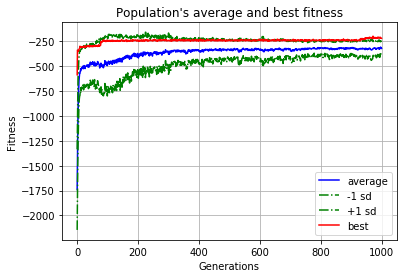

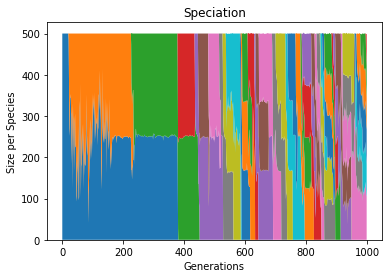

In [8]:
population = run(config_path)

In [9]:
winner = pickle.load(open("winner.pickle", "rb"))
winner

In [12]:
# Load configuration.
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)
# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

# Show output of the most fit genome against training data.
print('\nOutput:')
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)

# Use whole dataset for validation
predictors = data.loc[:, 'Var1':'Var11'].values
labels = data.loc[:,'Var12']
outputs = [np.array([1 if x == idx-1 else 0 for x in range(10)]) for idx in labels]

# setup confusion matrix
confusion = np.zeros([10,10])

N_perfect = 0
N_near = 0
N_far = 0

for xi, xo in zip(predictors, outputs):
    output = winner_net.activate(xi)
    print("input {!r}\nexpected output {!r}\ngot {!r}".format(xi, xo, output))
    expected = xo.tolist().index(max(xo))
    prediction = output.index(max(output))
    print(f"EXP: {expected}")
    print(f"PRD: {prediction}")
    confusion[expected][prediction] += 1
    if expected == prediction:
        N_perfect += 1
    elif np.abs(expected-prediction) == 1:
        N_near += 1
    else:
        N_far += 1

score = (2*N_perfect + N_near - 2*N_far)/1000

print(f"SCORE: {score}")

print(confusion)
print(f"N_perfect: {N_perfect}")
print(f"N_near: {N_near}")
print(f"N_far: {N_far}")



Best genome:
Key: 451464
Fitness: -219.98763021662776
Nodes:
	0 DefaultNodeGene(key=0, bias=-1.4691618122989434, response=1.0, activation=sigmoid, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=1.4344711543399475, response=1.0, activation=sigmoid, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=-1.842711698670649, response=1.0, activation=sigmoid, aggregation=sum)
	3 DefaultNodeGene(key=3, bias=0.9552285670064627, response=1.0, activation=sigmoid, aggregation=sum)
	4 DefaultNodeGene(key=4, bias=-0.464671095726052, response=1.0, activation=sigmoid, aggregation=sum)
	5 DefaultNodeGene(key=5, bias=0.10529554406488945, response=1.0, activation=sigmoid, aggregation=sum)
	6 DefaultNodeGene(key=6, bias=-0.6099406274633958, response=1.0, activation=sigmoid, aggregation=sum)
	7 DefaultNodeGene(key=7, bias=-1.0668632335802875, response=1.0, activation=sigmoid, aggregation=sum)
	8 DefaultNodeGene(key=8, bias=-0.6315909394680975, response=1.0, activation=sigmoid, aggregation=sum)
	9 DefaultNodeG

EXP: 4
PRD: 4
input array([ 7.9   ,  0.43  ,  0.21  ,  1.6   ,  0.106 , 10.    , 37.    ,
        0.9966,  3.17  ,  0.91  ,  9.5   ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5529712900700499, 0.48853505420883814, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 4
input array([ 8.7   ,  0.29  ,  0.52  ,  1.6   ,  0.113 , 12.    , 37.    ,
        0.9969,  3.25  ,  0.58  ,  9.5   ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5529242233333742, 0.47909613525728934, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 4
input array([ 6.4   ,  0.4   ,  0.23  ,  1.6   ,  0.066 ,  5.    , 12.    ,
        0.9958,  3.34  ,  0.56  ,  9.2   ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5703626987694154, 0.5424256467981176, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 4
input array([ 6.6   ,  0.705 ,  0.07  ,  1.6   ,  0.076 ,  6.    , 15.    ,
        0.9962,  3.44  ,  0.58  , 10.7   ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0

EXP: 4
PRD: 4
input array([ 7.8    ,  0.55   ,  0.     ,  1.7    ,  0.07   ,  7.     ,
       17.     ,  0.99659,  3.26   ,  0.64   ,  9.4    ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5591988529095463, 0.5370603277316766, 0.0, 0.0, 0.0, 0.0]
EXP: 5
PRD: 4
input array([ 7.5    ,  0.61   ,  0.2    ,  1.7    ,  0.076  , 36.     ,
       60.     ,  0.99494,  3.1    ,  0.4    ,  9.3    ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5650605993506312, 0.5289966181212185, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 4
input array([ 7.4    ,  0.74   ,  0.07   ,  1.7    ,  0.086  , 15.     ,
       48.     ,  0.99502,  3.12   ,  0.48   , 10.     ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5173598591562346, 0.5155254829369512, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 4
input array([ 9.8   ,  0.3   ,  0.39  ,  1.7   ,  0.062 ,  3.    ,  9.    ,
        0.9948,  3.14  ,  0.57  , 11.5   ])
expected outpu

PRD: 5
input array([7.7000e+00, 5.8000e-01, 1.0000e-02, 1.8000e+00, 8.8000e-02,
       1.2000e+01, 1.8000e+01, 9.9568e-01, 3.3200e+00, 5.6000e-01,
       1.0500e+01])
expected output array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.4711145881423997, 0.5128279167420359, 0.0, 0.0, 0.0, 0.0]
EXP: 6
PRD: 5
input array([7.7000e+00, 5.8000e-01, 1.0000e-02, 1.8000e+00, 8.8000e-02,
       1.2000e+01, 1.8000e+01, 9.9568e-01, 3.3200e+00, 5.6000e-01,
       1.0500e+01])
expected output array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.4711145881423997, 0.5128279167420359, 0.0, 0.0, 0.0, 0.0]
EXP: 6
PRD: 5
input array([7.3000e+00, 5.5000e-01, 1.0000e-02, 1.8000e+00, 9.3000e-02,
       9.0000e+00, 1.5000e+01, 9.9514e-01, 3.3500e+00, 5.8000e-01,
       1.1000e+01])
expected output array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.41669630038234595, 0.5060810747091585, 0.0, 0.0, 0.0, 0.0]
EXP: 6
PRD: 5
input array([ 7.3    ,  0.91   ,  0.1    ,  1.8    , 

input array([ 7.8   ,  0.46  ,  0.26  ,  1.9   ,  0.088 , 23.    , 53.    ,
        0.9981,  3.43  ,  0.74  ,  9.2   ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5703883436643311, 0.5128279167420359, 0.0, 0.0, 0.0, 0.0]
EXP: 5
PRD: 4
input array([ 7.1   ,  0.735 ,  0.16  ,  1.9   ,  0.1   , 15.    , 77.    ,
        0.9966,  3.27  ,  0.64  ,  9.3   ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.565322433818414, 0.496632324542668, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 4
input array([7.000e+00, 5.800e-01, 1.200e-01, 1.900e+00, 9.100e-02, 3.400e+01,
       1.240e+02, 9.956e-01, 3.440e+00, 4.800e-01, 1.050e+01])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.4711145881423997, 0.5087802150167612, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 5
input array([ 9.5   ,  0.78  ,  0.22  ,  1.9   ,  0.077 ,  6.    , 32.    ,
        0.9988,  3.26  ,  0.56  , 10.6   ])
expected output array([0, 0, 0, 0, 0, 1, 

input array([11.    ,  0.2   ,  0.48  ,  2.    ,  0.343 ,  6.    , 18.    ,
        0.9979,  3.3   ,  0.71  , 10.5   ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.4708148395385922, 0.20989705242783982, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 4
input array([ 7.1    ,  0.63   ,  0.06   ,  2.     ,  0.083  ,  8.     ,
       29.     ,  0.99855,  3.67   ,  0.73   ,  9.6    ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5466868412097682, 0.5195700875329096, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 4
input array([7.90e+00, 5.30e-01, 2.40e-01, 2.00e+00, 7.20e-02, 1.50e+01,
       1.05e+02, 9.96e-01, 3.27e+00, 5.40e-01, 9.40e+00])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5591797571119319, 0.534374367789587, 0.0, 0.0, 0.0, 0.0]
EXP: 5
PRD: 4
input array([10.7   ,  0.46  ,  0.39  ,  2.    ,  0.061 ,  7.    , 15.    ,
        0.9981,  3.18  ,  0.62  ,  9.5   ])
expected output array([0, 0, 0, 0, 1, 0

EXP: 4
PRD: 4
input array([9.0000e+00, 6.0000e-01, 2.9000e-01, 2.0000e+00, 6.9000e-02,
       3.2000e+01, 7.3000e+01, 9.9654e-01, 3.3400e+00, 5.7000e-01,
       1.0000e+01])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5169361648964822, 0.5384025114344393, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 5
input array([ 8.     ,  0.83   ,  0.27   ,  2.     ,  0.08   , 11.     ,
       63.     ,  0.99652,  3.29   ,  0.48   ,  9.8    ])
expected output array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.533417381403914, 0.523612128675716, 0.0, 0.0, 0.0, 0.0]
EXP: 3
PRD: 4
input array([7.2000e+00, 5.6000e-01, 2.6000e-01, 2.0000e+00, 8.3000e-02,
       1.3000e+01, 1.0000e+02, 9.9586e-01, 3.2600e+00, 5.2000e-01,
       9.9000e+00])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5248716981779762, 0.5195700875329096, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 4
input array([ 7.2    ,  0.45   ,  0.15   ,  2.     ,  0.078  , 10.     ,
     

input array([7.7000e+00, 7.1500e-01, 1.0000e-02, 2.1000e+00, 6.4000e-02,
       3.1000e+01, 4.3000e+01, 9.9371e-01, 3.4100e+00, 5.7000e-01,
       1.1800e+01])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.32203890735255913, 0.5451046990210953, 0.0, 0.0, 0.0, 0.0]
EXP: 5
PRD: 5
input array([10.4    ,  0.38   ,  0.46   ,  2.1    ,  0.104  ,  6.     ,
       10.     ,  0.99664,  3.12   ,  0.65   , 11.8    ])
expected output array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.32125281694769864, 0.4912336857583119, 0.0, 0.0, 0.0, 0.0]
EXP: 6
PRD: 5
input array([7.7000e+00, 7.1500e-01, 1.0000e-02, 2.1000e+00, 6.4000e-02,
       3.1000e+01, 4.3000e+01, 9.9371e-01, 3.4100e+00, 5.7000e-01,
       1.1800e+01])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.32203890735255913, 0.5451046990210953, 0.0, 0.0, 0.0, 0.0]
EXP: 5
PRD: 5
input array([ 7.6    ,  0.715  ,  0.     ,  2.1    ,  0.068  , 30.     ,
       35.    

EXP: 6
PRD: 4
input array([ 9.4  ,  0.34 ,  0.37 ,  2.2  ,  0.075,  5.   , 13.   ,  0.998,
        3.22 ,  0.62 ,  9.2  ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5703451348392506, 0.5303417359081078, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 4
input array([ 7.6   ,  0.62  ,  0.32  ,  2.2   ,  0.082 ,  7.    , 54.    ,
        0.9966,  3.36  ,  0.52  ,  9.4   ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.559287977907628, 0.5209177454782842, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 4
input array([ 7.4   ,  0.55  ,  0.22  ,  2.2   ,  0.106 , 12.    , 72.    ,
        0.9959,  3.05  ,  0.63  ,  9.2   ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5704504312523871, 0.48853505420883814, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 4
input array([10.6  ,  0.48 ,  0.64 ,  2.2  ,  0.111,  6.   , 20.   ,  0.997,
        3.26 ,  0.66 , 11.7  ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 

input array([11.1    ,  0.44   ,  0.42   ,  2.2    ,  0.064  , 14.     ,
       19.     ,  0.99758,  3.25   ,  0.57   , 10.4    ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.4808368468993818, 0.5451046990210953, 0.0, 0.0, 0.0, 0.0]
EXP: 5
PRD: 5
input array([ 7.3    ,  0.735  ,  0.     ,  2.2    ,  0.08   , 18.     ,
       28.     ,  0.99765,  3.41   ,  0.6    ,  9.4    ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5595503755539398, 0.523612128675716, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 4
input array([ 6.6    ,  0.88   ,  0.04   ,  2.2    ,  0.066  , 12.     ,
       20.     ,  0.99636,  3.53   ,  0.56   ,  9.9    ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5262715899588685, 0.5424256467981176, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 5
input array([ 6.4   ,  0.36  ,  0.53  ,  2.2   ,  0.23  , 19.    , 35.    ,
        0.9934,  3.37  ,  0.93  , 12.4   ])
expected output array([0, 0, 

PRD: 5
input array([ 6.1    ,  0.32   ,  0.25   ,  2.3    ,  0.071  , 23.     ,
       58.     ,  0.99633,  3.42   ,  0.97   , 10.6    ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.4605799034589319, 0.5357176067627241, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 5
input array([ 6.1    ,  0.32   ,  0.25   ,  2.3    ,  0.071  , 23.     ,
       58.     ,  0.99633,  3.42   ,  0.97   , 10.6    ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.4605799034589319, 0.5357176067627241, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 5
input array([ 8.4   ,  0.37  ,  0.43  ,  2.3   ,  0.063 , 12.    , 19.    ,
        0.9955,  3.17  ,  0.81  , 11.2   ])
expected output array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.393038289132287, 0.5464432564406999, 0.0, 0.0, 0.0, 0.0]
EXP: 6
PRD: 5
input array([ 7.1    ,  0.68   ,  0.     ,  2.3    ,  0.087  , 17.     ,
       26.     ,  0.99783,  3.45   ,  0.53   ,  9.5    ])
expected output array(

In [13]:
val_data = pd.read_csv('val_true.csv')
val_data.head()

,Val1,Val2,Val3,Val4,Val5,Val6,Val7,Val8,Val9,Val10,Val11,Val12
0,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,5.0
1,7.3,0.580,0.30,2.4,0.074,15.0,55.0,0.99680,3.46,0.59,10.2,5.0
2,7.8,0.735,0.08,2.4,0.092,10.0,41.0,0.99740,3.24,0.71,9.8,6.0
3,7.8,0.530,0.33,2.4,0.080,24.0,144.0,0.99655,3.30,0.60,9.5,5.0
4,12.5,0.560,0.49,2.4,0.064,5.0,27.0,0.99990,3.08,0.87,10.9,5.0


In [23]:
# Load configuration.
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)
# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

# Show output of the most fit genome against training data.
print('\nOutput:')
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)

# Use whole dataset for validation
predictors = val_data.loc[:, 'Val1':'Val11'].values
labels = val_data.loc[:,'Val12']
outputs = [np.array([1 if x == idx-1 else 0 for x in range(10)]) for idx in labels]

# setup confusion matrix
confusion = np.zeros([10,10])

N_perfect = 0
N_near = 0
N_far = 0

for xi, xo in zip(predictors, outputs):
    output = winner_net.activate(xi)
    print("input {!r}\nexpected output {!r}\ngot {!r}".format(xi, xo, output))
    expected = xo.tolist().index(max(xo))
    prediction = output.index(max(output))
    print(f"EXP: {expected}")
    print(f"PRD: {prediction}")
    confusion[expected][prediction] += 1
    if expected == prediction:
        N_perfect += 1
    elif np.abs(expected-prediction) == 1:
        N_near += 1
    else:
        N_far += 1

score = (2*N_perfect + N_near - 2*N_far)/val_data.count()[0]

print(f"SCORE: {score}")

print(confusion)
print(f"N_perfect: {N_perfect}")
print(f"N_near: {N_near}")
print(f"N_far: {N_far}")



Best genome:
Key: 451464
Fitness: -219.98763021662776
Nodes:
	0 DefaultNodeGene(key=0, bias=-1.4691618122989434, response=1.0, activation=sigmoid, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=1.4344711543399475, response=1.0, activation=sigmoid, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=-1.842711698670649, response=1.0, activation=sigmoid, aggregation=sum)
	3 DefaultNodeGene(key=3, bias=0.9552285670064627, response=1.0, activation=sigmoid, aggregation=sum)
	4 DefaultNodeGene(key=4, bias=-0.464671095726052, response=1.0, activation=sigmoid, aggregation=sum)
	5 DefaultNodeGene(key=5, bias=0.10529554406488945, response=1.0, activation=sigmoid, aggregation=sum)
	6 DefaultNodeGene(key=6, bias=-0.6099406274633958, response=1.0, activation=sigmoid, aggregation=sum)
	7 DefaultNodeGene(key=7, bias=-1.0668632335802875, response=1.0, activation=sigmoid, aggregation=sum)
	8 DefaultNodeGene(key=8, bias=-0.6315909394680975, response=1.0, activation=sigmoid, aggregation=sum)
	9 DefaultNodeG

input array([11.9   ,  0.58  ,  0.66  ,  2.5   ,  0.072 ,  6.    , 37.    ,
        0.9992,  3.05  ,  0.56  , 10.    ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5169002987127631, 0.534374367789587, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 5
input array([ 8.3   ,  0.42  ,  0.38  ,  2.5   ,  0.094 , 24.    , 60.    ,
        0.9979,  3.31  ,  0.7   , 10.8   ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.4391348048395193, 0.5047313617764356, 0.0, 0.0, 0.0, 0.0]
EXP: 5
PRD: 5
input array([ 9.6   ,  0.38  ,  0.31  ,  2.5   ,  0.096 , 16.    , 49.    ,
        0.9982,  3.19  ,  0.7   , 10.    ])
expected output array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5167082423117688, 0.5020317486921927, 0.0, 0.0, 0.0, 0.0]
EXP: 6
PRD: 4
input array([ 9.8   ,  0.44  ,  0.47  ,  2.5   ,  0.063 ,  9.    , 28.    ,
        0.9981,  3.24  ,  0.65  , 10.8   ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0

input array([ 8.6   ,  0.45  ,  0.31  ,  2.6   ,  0.086 , 21.    , 50.    ,
        0.9982,  3.37  ,  0.91  ,  9.9   ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.524759113947146, 0.5155254829369512, 0.0, 0.0, 0.0, 0.0]
EXP: 5
PRD: 4
input array([10.4  ,  0.575,  0.61 ,  2.6  ,  0.076, 11.   , 24.   ,  1.   ,
        3.16 ,  0.69 ,  9.   ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5804458350714016, 0.5289966181212185, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 4
input array([11.5   ,  0.59  ,  0.59  ,  2.6   ,  0.087 , 13.    , 49.    ,
        0.9988,  3.18  ,  0.65  , 11.    ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.41678560631440803, 0.514176803085154, 0.0, 0.0, 0.0, 0.0]
EXP: 5
PRD: 5
input array([11.5   ,  0.59  ,  0.59  ,  2.6   ,  0.087 , 13.    , 49.    ,
        0.9988,  3.18  ,  0.65  , 11.    ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0,

got [0.0, 0.0, 0.0, 0.0, 0.3211748122751842, 0.5424256467981176, 0.0, 0.0, 0.0, 0.0]
EXP: 5
PRD: 5
input array([ 6.8    ,  0.64   ,  0.     ,  2.7    ,  0.123  , 15.     ,
       33.     ,  0.99538,  3.44   ,  0.63   , 11.3    ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.3815729297442535, 0.4656394715723417, 0.0, 0.0, 0.0, 0.0]
EXP: 5
PRD: 5
input array([ 6.8    ,  0.64   ,  0.     ,  2.7    ,  0.123  , 15.     ,
       33.     ,  0.99538,  3.44   ,  0.63   , 11.3    ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.3815729297442535, 0.4656394715723417, 0.0, 0.0, 0.0, 0.0]
EXP: 5
PRD: 5
input array([ 8.7    ,  0.63   ,  0.28   ,  2.7    ,  0.096  , 17.     ,
       69.     ,  0.99734,  3.26   ,  0.63   , 10.2    ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.4998380566389349, 0.5020317486921927, 0.0, 0.0, 0.0, 0.0]
EXP: 5
PRD: 5
input array([ 7.8    ,  0.32   ,  0.44   ,  2.7  

EXP: 4
PRD: 5
input array([ 8.2    ,  0.28   ,  0.6    ,  3.     ,  0.104  , 10.     ,
       22.     ,  0.99828,  3.39   ,  0.68   , 10.6    ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.4605651501072363, 0.4912336857583119, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 5
input array([11.1   ,  0.35  ,  0.48  ,  3.1   ,  0.09  ,  5.    , 21.    ,
        0.9986,  3.17  ,  0.53  , 10.5   ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.4708621263149815, 0.5101296030722101, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 5
input array([11.9  ,  0.43 ,  0.66 ,  3.1  ,  0.109, 10.   , 23.   ,  1.   ,
        3.15 ,  0.85 , 10.4  ])
expected output array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.4808287945159114, 0.4844884087244799, 0.0, 0.0, 0.0, 0.0]
EXP: 6
PRD: 5
input array([12.3   ,  0.27  ,  0.49  ,  3.1   ,  0.079 , 28.    , 46.    ,
        0.9993,  3.2   ,  0.8   , 10.2   ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 

input array([15.5    ,  0.645  ,  0.49   ,  4.2    ,  0.095  , 10.     ,
       23.     ,  1.00315,  2.92   ,  0.74   , 11.1    ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.4053197292573822, 0.503381579880094, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 5
input array([15.5    ,  0.645  ,  0.49   ,  4.2    ,  0.095  , 10.     ,
       23.     ,  1.00315,  2.92   ,  0.74   , 11.1    ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.4053197292573822, 0.503381579880094, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 5
input array([15.6    ,  0.645  ,  0.49   ,  4.2    ,  0.095  , 10.     ,
       23.     ,  1.00315,  2.92   ,  0.74   , 11.1    ])
expected output array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.4053197292573822, 0.503381579880094, 0.0, 0.0, 0.0, 0.0]
EXP: 4
PRD: 5
input array([ 8.3   ,  0.76  ,  0.29  ,  4.2   ,  0.075 , 12.    , 16.    ,
        0.9965,  3.45  ,  0.68  , 11.5   ])
expected output array([0, 0, 0,

EXP: 5
PRD: 5
input array([ 6.8    ,  0.41   ,  0.31   ,  8.8    ,  0.084  , 26.     ,
       45.     ,  0.99824,  3.38   ,  0.64   , 10.1    ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.5083248956268581, 0.5182221447483604, 0.0, 0.0, 0.0, 0.0]
EXP: 5
PRD: 5
input array([ 9.5    ,  0.39   ,  0.41   ,  8.9    ,  0.069  , 18.     ,
       39.     ,  0.99859,  3.29   ,  0.81   , 10.9    ])
expected output array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.42792781353466264, 0.5384025114344393, 0.0, 0.0, 0.0, 0.0]
EXP: 6
PRD: 5
input array([ 9.1    ,  0.28   ,  0.46   ,  9.     ,  0.114  ,  3.     ,
        9.     ,  0.99901,  3.18   ,  0.6    , 10.9    ])
expected output array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
got [0.0, 0.0, 0.0, 0.0, 0.4278719780573102, 0.4777487784643723, 0.0, 0.0, 0.0, 0.0]
EXP: 5
PRD: 5
input array([6.900e+00, 6.050e-01, 1.200e-01, 1.070e+01, 7.300e-02, 4.000e+01,
       8.300e+01, 9.993e-01, 3.450e+00, 5.200e-01, 9.4

In [22]:
val_data.count()[0]


599